# Enhanced protein isoform characterization through long-read proteogenomics 
## Supplementary Note 3
---
Ben Jordan | Gloria Sheynkman | Simi Kaur

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as npf 
import math
import matplotlib.cm as cm  
from matplotlib.colors import Normalize
import os
import os, sys, shutil
import matplotlib
import shutil


import config

matplotlib.rc('font', **config.font)
# will run pipeline on and filtered database
pep_recoveries_file = f'{config.PIPELINE_RESULTS_DIRECTORY}/peptide_analysis/gc_pb_overlap_peptides.tsv'
gene_level_file = f'{config.PIPELINE_RESULTS_DIRECTORY}/transcriptome_summary/gene_level_tab.tsv'

pep_recoveries_full = pd.read_table(pep_recoveries_file)
gene_info = pd.read_table(gene_level_file)

def relationship_cpm_length_peptide_coverage_gene_fraction(pep_recoveries, database):
    ### display relationship between cpm, length, and peptide coverage

    # fraction of genes detected in refined db at different cpm thresholds
    data = []
    for min_cpm in (1, 3, 10, 100):
        peps_over_cpm = pep_recoveries[pep_recoveries.cpm > min_cpm]
        num_genes_over_cpm = peps_over_cpm.gene.nunique()
        num_genes_in_db_over_cpm = peps_over_cpm[peps_over_cpm[f'in_{database}'] == 1].gene.nunique()
        num_genes_exact_over_cpm = peps_over_cpm[peps_over_cpm[f'frac_peps_in_{database}']==1].gene.nunique()

        data.append([min_cpm, num_genes_in_db_over_cpm, num_genes_exact_over_cpm, num_genes_over_cpm, num_genes_in_db_over_cpm/num_genes_over_cpm, num_genes_exact_over_cpm/num_genes_over_cpm])
    df_cpm = pd.DataFrame(data, columns = ['min_cpm', f'{database}_gene_size', f'{database}_exact_gene_size','gencode_gene_size', f'{database}_frac', f'{database}_frac_exact'])
    df_cpm = df_cpm.set_index('min_cpm')
    fig, ax = plt.subplots(figsize=(4.5,5))

    # plot when any peptides are present
    p = ax.bar(range(4), df_cpm[f'{database}_frac'], tick_label=[1, 3, 10, 100], edgecolor='black', width=0.7, zorder=10)
    ax.bar_label(p, fmt='%1.2g', padding=5)
    # add the number of genes within each cpm threshold onto the bar
    for i in range(len(df_cpm)):
        # plt.text(x=i, y=float(df_cpm['refine_frac'].iloc[i]), s=df_cpm.num_genes)
        plt.text(x=i-0.23, y=0.6, s=f' N =\n{df_cpm.gencode_gene_size.iloc[i]}', zorder=50, size=14)
    ax.set_ylim(0, 1.15)
    plt.xlabel('Gene abundance threshold (CPM)')
    plt.ylabel('Fraction of genes with peptides recovered')
    # plt.title('Fraction of genes detected by GENCODE search\nthat are represented in the refined PacBio database', pad=20)
    plt.grid(zorder=0, axis='y')
    ax.get_figure().savefig(f'plot/FigS3.1_plot_bar_genes_frac_w_pep_ids_at_diff_cpm_cutoff.pdf', bbox_inches='tight')
    plt.clf()

    # plot when gencode and pacbio database have exactly the same peptides
    fig, ax = plt.subplots(figsize=(4.5,5))
    p = ax.bar(range(4), df_cpm[f'{database}_frac_exact'], tick_label=[1, 3, 10, 100], edgecolor='black', width=0.7, zorder=10)
    ax.bar_label(p, fmt='%1.2g', padding=5)
    # add the number of genes within each cpm threshold onto the bar
    for i in range(len(df_cpm)):
        # plt.text(x=i, y=float(df_cpm['refine_frac'].iloc[i]), s=df_cpm.num_genes)
        plt.text(x=i-0.23, y=0.6, s=f' N =\n{df_cpm.gencode_gene_size.iloc[i]}', zorder=50, size=14)
    ax.set_ylim(0, 1.15)
    plt.xlabel('Gene abundance threshold (CPM)')
    plt.ylabel('Fraction of genes with all peptides recovered')
    # plt.title('Fraction of genes detected by GENCODE search\nthat are represented in the refined PacBio database', pad=20)
    plt.grid(zorder=0, axis='y')
    ax.get_figure().savefig(f'plot/FigS3.1_plot_bar_genes_frac_w_all_peps_recovered_diff_cpm_cutoff.pdf', bbox_inches='tight')

    df_cpm = df_cpm.reset_index()
    df_cpm.columns = ['Gene expression threshold (CPM)', f'Number of genes in {database} in space',f'Number of genes in {database} in space where all peptides are recovered','Number of genes in GENCODE in space', f'Fraction {database}/GENCODE genes', f'Fraction {database}/GENCODE genes where all peptides are recovered']

    df_cpm.to_csv(f'stats/FigS3.1_genes_frac_w_pep_ids_at_diff_cpm_cutoff.tsv', sep='\t', index=None)


def dist_avg_gene_length(pep_recoveries, database):
    # distr of avg gene length for no, incomplete, and full peptide coverage
    fig, axs = plt.subplots(3, figsize=(4,6))
    axs[0].hist(pep_recoveries[pep_recoveries[f'frac_peps_in_{database}'] == 1]['avg_len'], alpha=0.3, label='Full coverage', bins=30, edgecolor='black', color='gold')
    axs[0].set_title('Full peptide coverage', fontsize=16)
    axs[1].hist(pep_recoveries[(pep_recoveries[f'frac_peps_in_{database}'] < 1) & (pep_recoveries[f'frac_peps_in_{database}'] > 0)]['avg_len'], alpha=0.5, label='Incomplete coverage', bins=30, edgecolor='black', color='darkorange')
    axs[1].set_title('Incomplete peptide coverage', y=1, fontsize=16)
    axs[2].hist(pep_recoveries[(pep_recoveries[f'frac_peps_in_{database}'] == 0)]['avg_len'], alpha=0.8, label='No coverage', bins=60, edgecolor='black', color='indigo')
    axs[2].set_title('No peptide coverage', y=1, fontsize=16)
    axs[2].set_xlabel('Average transcript length of gene\n(nucleotides)')
    fig.text(0, 0.5, 'Count', va='center', rotation='vertical')
    for ax in axs:
        ax.set_xlim(0, 13000)
    fig.tight_layout()
    fig.savefig(f'plot/FigS3.1_plot_distr_gene_len_for_diff_{database}_coverage.pdf')

   
def dist_avg_gene_abundance(pep_recoveries, database):
    # distr of avg gene abundance for no, incomplete, and full peptide coverage
    fig, axs = plt.subplots(3, figsize=(4, 6),sharex=True)
    axs[0].hist(pep_recoveries[pep_recoveries[f'frac_peps_in_{database}'] == 1]['log2cpm'], alpha=0.3, label='Full coverage', bins=20, edgecolor='black', color='gold')
    axs[0].set_title('Full peptide coverage', fontsize=16)
    axs[1].hist(pep_recoveries[(pep_recoveries[f'frac_peps_in_{database}'] < 1) & (pep_recoveries[f'frac_peps_in_{database}'] > 0)]['log2cpm'], alpha=0.5, label='Incomplete coverage', bins=20, edgecolor='black', color='darkorange')
    axs[1].set_title('Incomplete peptide coverage', y=1, fontsize=16)
    axs[2].hist(pep_recoveries[(pep_recoveries[f'frac_peps_in_{database}'] == 0)]['log2cpm'], alpha=0.8, label='No coverage', bins=20, edgecolor='black', color='indigo')
    axs[2].set_title('No peptide coverage', y=1, fontsize=16)
    axs[2].set_xlabel('Transcriptional abundance of gene\n($log_2$(CPM+1))')
    fig.text(0, 0.5, 'Count', va='center', rotation='vertical')
    fig.tight_layout()
    fig.savefig(f'plot/FigS3.1_plot_distr_gene_abund_for_diff_{database}_coverage.pdf')

def fractional_recovery_of_genes(pep_recoveries, database, max_gene=15000):
    # fractional recovery of genes as a function of abundance and length
    # (source data for 3d plot)
    
    with open(f'stats/FigS3.1_frac_status_vs_cpm_vs_len_{database}.tsv', 'w') as ofile:
        ofile.write(f'log2cpm\tlen\tgc_peps\tfrac_{database}\tN\n')
        delta = 500
        step=1
        max_log2cpm = int(pep_recoveries[ (pep_recoveries[f'in_{database}'] == 1)]['log2cpm'].max())
        frame_peptide = pep_recoveries[pep_recoveries[f"in_{database}"] == 1]
        frame_peptide = frame_peptide[frame_peptide['avg_len'] < max_gene]
        max_len = int(frame_peptide['avg_len'].max()) + delta
        frame_peptide = pep_recoveries
        for ln in range(500, max_len, 1000):
            filtered_length = frame_peptide[frame_peptide.avg_len.between(ln-delta, ln)]
            for log2cpm in np.arange(0, max_log2cpm,step):
                filtered_cpm = filtered_length[filtered_length['log2cpm'].between(log2cpm, log2cpm+step)]
                gc = filtered_cpm.peps_in_gc.sum()
                frm = filtered_cpm[f"frac_peps_in_{database}"].mean()
                num_entries = filtered_cpm.shape[0]
                if num_entries > 0:
                    ofile.write('\t'.join(map(str, [log2cpm, ln, gc, frm, num_entries])) + '\n')


def plot_3d_of_gene_recovery(database):
    # make 3d plot of gene recovery as a function of abundance and length
    fontsize = 16
    fontweight='normal'
    
    fraction_status_vs_cpm_vs_len = pd.read_table(f'stats/FigS3.1_frac_status_vs_cpm_vs_len_{database}.tsv')
    fraction_status_vs_cpm_vs_len = fraction_status_vs_cpm_vs_len[['log2cpm', 'len', 'N', f"frac_{database}"]]
    # setup figure and axes
    fig = plt.figure(figsize=(12, 8),tight_layout=True, dpi=100)
    ax1 = fig.add_subplot(121, projection='3d')
    # setup data
    x = fraction_status_vs_cpm_vs_len['log2cpm'].values
    y = fraction_status_vs_cpm_vs_len.len.values
    num_elements = len(x)
    z = np.zeros(num_elements)
    dx = .4*np.ones(len(x))
    dy = 400*np.ones(len(y))
    dz = fraction_status_vs_cpm_vs_len.N.values
    frac = fraction_status_vs_cpm_vs_len[f"frac_{database}"].fillna(0).values
    cmap = cm.get_cmap('magma')
    norm = Normalize(vmin=0, vmax=max(frac))
    colors = cmap(norm(frac))
    ax1.bar3d(x, y, z, dx, dy, dz, color=colors, edgecolor = 'black', linewidth = 1, alpha = 1)
    ax1.set_xlabel('$log_2$(CPM+1)', fontsize=fontsize, fontweight=fontweight, labelpad=5)
    ax1.set_ylabel('Average transcript\nlength (bp)', fontsize=fontsize, fontweight=fontweight, labelpad=13)
    # ax1.set_yticklabels([0, 2500, 5000, 7500, 10000, 12500, 15000], fontdict={'verticalalignment':'top', 'horizontalalignment':'center'})
    ax1.set_zlabel('Number of genes', fontsize=fontsize, fontweight=fontweight)
    ax1.set_facecolor('white')
    ax1.view_init(32, 135)
    ax1.tick_params(pad=0)
    # ax1.view_init(elev=30, azim=145)
    sc = cm.ScalarMappable(cmap=cmap,norm=norm)
    sc.set_array([])
    cbar = plt.colorbar(sc, shrink=0.3, pad=0.15, label='Fraction of genes fully recovered', orientation='vertical')
    ax1.grid(b=True)
    plt.savefig(f'plot/FigS3.2_plot_3d_{database}_status_vs_len_vs_cpm.pdf', bbox_inches='tight')
    plt.show()
    
def database_analysis(pep_recoveries, gene_info, database):
    # all plots go into a directory

    # if not os.path.exists(f'results_{database}_db/plot'):
    #     os.makedirs(f'results_{database}_db/plot')

    # # all statistics go into a directory
    # if not os.path.exists(f'results_{database}_db/stats'):
    #     os.makedirs(f'results_{database}_db/stats')

    # add in gene properties into peptide recovery table
    pep_recoveries = pep_recoveries.merge(gene_info, how='left', on='gene')
    pep_recoveries['log2cpm'] = pep_recoveries.cpm.apply(lambda x: math.log(x+1, 2))
    pep_recoveries['log2tpm'] = pep_recoveries.tpm.apply(lambda x: math.log(x+1, 2))
    pep_recoveries = pep_recoveries[['gene', 'gc_peps', 'peps_in_gc', f'in_{database}', f'peps_in_{database}', f'frac_peps_in_{database}', 'avg_len', 'min_len', 'max_len', 'cpm', 'tpm', 'log2cpm', 'log2tpm']]
    pep_recoveries.to_csv(f'stats/FigS3.2_source_data_data_on_gencode_detected_vs_pacbio_present_peptides.tsv', sep='\t', index=None)

    # total peptide/protein id stats in gencode
    num_peps_gc = pep_recoveries.peps_in_gc.sum()
    num_genes_gc = pep_recoveries.shape[0]
    num_peps_database = pep_recoveries[f'peps_in_{database}'].sum()
    num_genes_database = pep_recoveries[f'in_{database}'].sum()
    with open(f'stats/FigS3.2_stats_peptide_summary_sums.tsv', 'w') as ofile: 
        ofile.write(f'Number of peptides identified in the GENCODE search:\t{num_peps_gc}\n')
        ofile.write(f'Number of GENCODE-search peptides in the refined PacBio database:\t{num_peps_database}\n')
        ofile.write(f'Number of genes with associated peptide evidence from the GENCODE search:\t{num_genes_gc}\n')
        ofile.write(f'Number of genes with associated peptide evidence in the refined PacBio database:\t{num_genes_database}\n')


    # relationship_cpm_length_peptide_coverage_gene_fraction(pep_recoveries, database)
    dist_avg_gene_length(pep_recoveries, database)
    dist_avg_gene_abundance(pep_recoveries, database)
    fractional_recovery_of_genes(pep_recoveries, database)
    plot_3d_of_gene_recovery(database)
    



# Filtered 

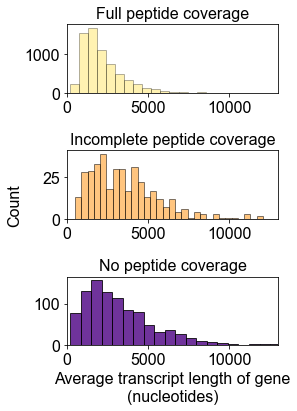

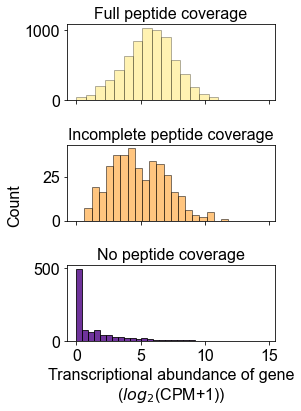

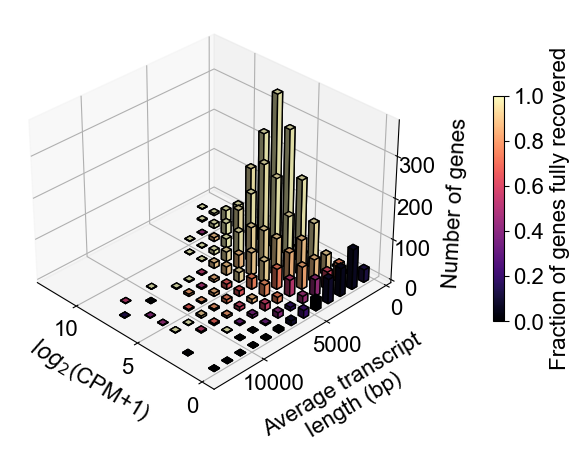

In [2]:

database = 'filtered'
# if not os.path.exists(f'results_{database}_db'):
#     os.makedirs(f'results_{database}_db')
# else:
#     shutil.rmtree(f'results_{database}_db')
#     os.makedirs(f'results_{database}_db')
database_analysis(pep_recoveries_full, gene_info, database)

In [3]:
df = pd.read_table(f'{config.PIPELINE_RESULTS_DIRECTORY}/novel_peptides/{config.EXPERIMENT_NAME}_hybrid.pacbio_novel_peptides.tsv')
# df = df.set_index(['gene','seq','score','qval'])
# df['acc'] = df['acc'].str.split('|')
# df = df['acc'].explode().reset_index()

In [4]:
df2 = (df.set_index(['gene', 'seq', 'score', 'qval'])
    .apply(lambda x: x.str.split('|').explode())
    .reset_index())

In [5]:
df.head()

,gene,acc,seq,score,qval
0,USP10,PB.12882.23,AAMALHSPQYIFGDFSPDEFNQFFVTPR,27.261,0.0
1,RABGAP1L,PB.1248.6,ESDKEEPVTPTSGGGPMSPQDDEAEEATGYR,26.256,0.0
2,RASA1,PB.4925.8,TDEQGLIVEDLVEEGREEDPHEGK,25.315,0.0
3,APEH,PB.3231.15|PB.3231.37,AGPDPGVSPAQVLLSEPEEAAALYR,21.245,0.0
4,CC2D1A,PB.14528.11,LANQDEGPEDEEDEQNSPVAPTAQPK,20.251,0.0


In [6]:
df2.head()

,gene,seq,score,qval,acc
0,USP10,AAMALHSPQYIFGDFSPDEFNQFFVTPR,27.261,0.0,PB.12882.23
1,RABGAP1L,ESDKEEPVTPTSGGGPMSPQDDEAEEATGYR,26.256,0.0,PB.1248.6
2,RASA1,TDEQGLIVEDLVEEGREEDPHEGK,25.315,0.0,PB.4925.8
3,APEH,AGPDPGVSPAQVLLSEPEEAAALYR,21.245,0.0,PB.3231.15
4,APEH,AGPDPGVSPAQVLLSEPEEAAALYR,21.245,0.0,PB.3231.37
